In [1]:
import h3
from PIL import Image, ImageDraw
import requests
from io import BytesIO, StringIO
from IPython.display import Image as IPythonImage
import numpy as np

In [2]:
hex_ = "892a3066aafffff"

boundary = h3.h3_to_geo_boundary(hex_)
min_lat = min([lat for lat, lon in boundary])
max_lat = max([lat for lat, lon in boundary])
min_lon = min([lon for lat, lon in boundary])
max_lon = max([lon for lat, lon in boundary])

In [3]:
mapbox_key = "pk.eyJ1IjoibWF4LXNjaHJhZGVyIiwiYSI6ImNrOHQxZ2s3bDAwdXQzbG81NjZpZm96bDEifQ.etUi4OK4ozzaP_P8foZn_A"
size = (800, 800)
style = "mapbox://styles/max-schrader/cldajslen000i01msl03pyjqo"


r = requests.get(
    f"https://api.mapbox.com/styles/v1/mapbox/satellite-v9/static/[{min_lon},{min_lat},{max_lon},{max_lat}]/{size[0]}x{size[1]}?access_token={mapbox_key}"
)

In [4]:
with open(f'{hex_}.png', 'wb') as f:
    f.write(r.content)

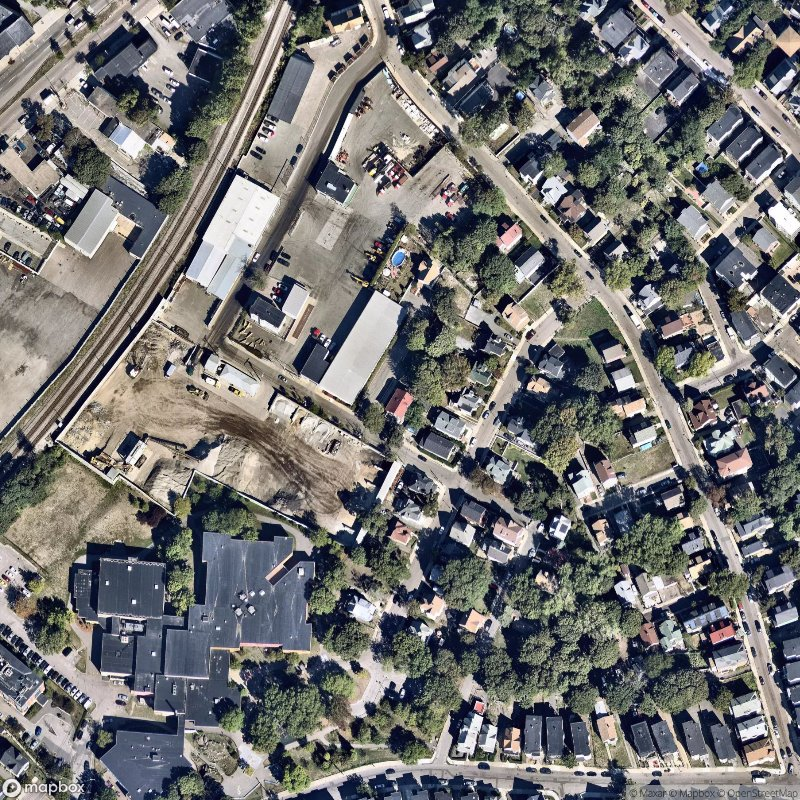

In [5]:
IPythonImage(
    f'{hex_}.png'
)

In [6]:
# read image as RGB (without alpha)
img = Image.open("test.png").convert("RGB")

# convert to numpy (for convenience)
img_array = np.asarray(img)

In [7]:
## Create the Outline Polygon in Image coordinates. 
## Get the polygon of the image itself first
from shapely.geometry import Polygon
from shapely.ops import transform
from pyproj import CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
from pyproj import Transformer

In [8]:
p = Polygon(boundary)

utm_crs_list = query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=AreaOfInterest(
        west_lon_degree=min_lon,
        south_lat_degree=min_lat,
        east_lon_degree=max_lon,
        north_lat_degree=max_lat,
    ),
)

utm_crs = CRS.from_epsg(utm_crs_list[0].code)
transformer = Transformer.from_crs("EPSG:4326", utm_crs)

transformed_polygon = transform(transformer.transform, p)
polygon_height = max(transformed_polygon.exterior.xy[1]) - min(transformed_polygon.exterior.xy[1])
polygon_width = max(transformed_polygon.exterior.xy[0]) - min(transformed_polygon.exterior.xy[0])
ref_y = min(transformed_polygon.exterior.xy[1])
ref_x = min(transformed_polygon.exterior.xy[0])


img_polygon = transform(lambda x, y: (int(((x - ref_x) / polygon_width) * size[0]), int(((y - ref_y) / polygon_height) * size[1])), transformed_polygon)

In [9]:
# create new image ("1-bit pixels, black and white", (width, height), "default color")
# mask_img = Image.new('1', (img_array.shape[1], img_array.shape[0]), 'white')

mask = np.zeros(img_array.shape[0:2], dtype=np.uint8)


In [10]:
import cv2

points = np.array([img_polygon.exterior.coords]).astype(int)
cv2.drawContours(mask, [points], -1, (255, 255, 255), -1, cv2.LINE_AA)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
img = cv2.imread(f"{hex_}.png")
# add an alpha channel


res = cv2.bitwise_and(img,img,mask = mask)
rect = cv2.boundingRect(points) # returns (x,y,w,h) of the rect
cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]

wbg = np.ones_like(img, np.uint8)*255
cv2.bitwise_not(wbg,wbg, mask=mask)
dst = wbg+res

cv2.imwrite(f"{hex_}_cropped.png", dst)

True

In [12]:
import geopandas as gpd

In [13]:
gpd.read_file('tl_2022_us_zcta520.shp')

DriverError: Unable to open tl_2022_us_zcta520.shx or tl_2022_us_zcta520.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.